<a href="https://colab.research.google.com/github/SLy-Precision/Player-Detection-and-Team-Performance-Prediction/blob/main/01_Modeling_Using_Data_%26_Creation_of_Advanced_Statistics_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📊 ⚽ Modeling Using Data and Creation Of Advanced 🐍tatistics 🔎 🕵️

## - Antonio Guerrero

## 📖 Creation of Advanced Characteristics DataFrame per Player ( Description of all them in the paper ) 📚

In [1]:
# Lets import the libraries we are gonna use 💻

# Statsbomb api and more
!pip install --quiet statsbombpy
!pip install --quiet mplsoccer
!pip install --quiet highlight_text

# Libraries for the data manipulation and plot
from statsbombpy import sb
from tqdm import tqdm
import pandas as pd
from mplsoccer import VerticalPitch, Pitch, Sbapi
from highlight_text import ax_text, fig_text
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import seaborn as sns
import numpy as np
from collections import defaultdict
from collections import Counter
from itertools import groupby
from mplsoccer import Pitch

# Libraries for networks
import networkx as nx
import community.community_louvain as community_louvain

# Libraries for ML
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import IsolationForest

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.4/86.4 kB 2.8 MB/s eta 0:00:00


In [2]:
# Lets get drive data (if u want to replicate use your directory)  🔵🔴🟡🟢

from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/My Drive/Proyect_Hackathon/'


df = pd.read_csv(path + 'Full_Dataset_2021-2025.csv')
df_players = pd.read_csv(path + 'df_players_info_full.csv')

# Lets get the array of the match ids (Just in case)

#Credentials for Statsbomb from ITAM (Again, thanks ITAM 🟢)
user = "itam_hackathon@hudl.com"
password = "pGwIprel"

# Save info
array_season_2021_2022 = sb.matches(competition_id=73, season_id=108, creds={"user": user, "passwd": password})['match_id'].to_list()
array_season_2022_2023 = sb.matches(competition_id=73, season_id=235, creds={"user": user, "passwd": password})['match_id'].to_list()
array_season_2023_2024 = sb.matches(competition_id=73, season_id=281, creds={"user": user, "passwd": password})['match_id'].to_list()
array_season_2024_2025 = sb.matches(competition_id=73, season_id=317, creds={"user": user, "passwd": password})['match_id'].to_list()

Mounted at /content/drive


In [3]:
# Lets check how see the columns of EventTypeId with number "19"

df.loc[df['EventTypeId'] == 19].head()

,matchId,playerId,home_team_id,away_team_id,home_team_name,away_team_name,eventSec,EventTypeId,period,minute,...,TimeDelta,under_pressure,counterpress,IsPossessionWinningAction,IsDribbledPast,statsbomb_xg,xA,obv_total_net,gk_save_difficulty_xg,gk_xg_prevented
1701,3799351,75306.0,1297,1287,Guadalajara,Atlético San Luis,0.000,19,2,45,...,0.000,0,0,0,0,NaN,NaN,NaN,NaN,NaN
2376,3799351,27891.0,1297,1287,Guadalajara,Atlético San Luis,1373.898,19,2,67,...,51.994,0,0,0,0,NaN,NaN,NaN,NaN,NaN
2377,3799351,29267.0,1297,1287,Guadalajara,Atlético San Luis,1386.175,19,2,68,...,12.277,0,0,0,0,NaN,NaN,NaN,NaN,NaN
2378,3799351,26312.0,1297,1287,Guadalajara,Atlético San Luis,1398.645,19,2,68,...,12.470,0,0,0,0,NaN,NaN,NaN,NaN,NaN
2537,3799351,26306.0,1297,1287,Guadalajara,Atlético San Luis,1999.249,19,2,78,...,17.726,0,0,0,0,NaN,NaN,NaN,NaN,NaN


In [4]:
# Lets create the df in which we are gonna put all the metrics per player

player_ids = df_players['playerId'].unique()
player_map = df_players.set_index('playerId')['playerName']

# Structure of df

all_metrics_cols = [
    'playerName',
    'minutesPlayed',
    'gk_GoalsPrevented_p90',
    'gk_AvgSaveDifficulty',
    'def_OBV_p90',
    'def_OppHalfRecoveries_p90',
    'def_DuelWinRate',
    'flow_WeightedDegree_p90',
    'flow_Betweenness',
    'flow_Eigenvector',
    'off_xGChain_p90',
    'off_FinishingDifferential',
    'off_OpportunityCreation_p90',
    'off_OBV_p90'
    'X_avg'
    'Y_avg'
]

# Create empty df
df_advanced = pd.DataFrame(index=player_ids, columns=all_metrics_cols)
df_advanced.index.name = 'playerId'

# Namesss
df_advanced['playerName'] = df_advanced.index.map(player_map)

# Print it
df_advanced.head()

,playerName,minutesPlayed,gk_GoalsPrevented_p90,gk_AvgSaveDifficulty,def_OBV_p90,def_OppHalfRecoveries_p90,def_DuelWinRate,flow_WeightedDegree_p90,flow_Betweenness,flow_Eigenvector,off_xGChain_p90,off_FinishingDifferential,off_OpportunityCreation_p90,off_OBV_p90X_avgY_avg
playerId,,,,,,,,,,,,,,
26289,Javier Güemez López,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26306,Adam Fernando Bareiro Gamarra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26331,Marcelo Barovero,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27083,Jhon Fredy Duque Arias,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27967,Unai Bilbao Arteta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df_advanced.info()

# We didnt lose any player, so we're right ✅

<class 'pandas.core.frame.DataFrame'>
Index: 1234 entries, 26289 to 360103
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   playerName                   1234 non-null   object
 1   minutesPlayed                0 non-null      object
 2   gk_GoalsPrevented_p90        0 non-null      object
 3   gk_AvgSaveDifficulty         0 non-null      object
 4   def_OBV_p90                  0 non-null      object
 5   def_OppHalfRecoveries_p90    0 non-null      object
 6   def_DuelWinRate              0 non-null      object
 7   flow_WeightedDegree_p90      0 non-null      object
 8   flow_Betweenness             0 non-null      object
 9   flow_Eigenvector             0 non-null      object
 10  off_xGChain_p90              0 non-null      object
 11  off_FinishingDifferential    0 non-null      object
 12  off_OpportunityCreation_p90  0 non-null      object
 13  off_OBV_p90X_avgY_avg        0 n

### ⏱️ Filling total time played ⏱️

In [6]:
# Lets start to fill all the columns for every player, we start with the time playerd

def calculate_minutes_played(df_events, df_advanced):
    """
    Calculates an accurate total of minutes played for each player using the duration of their event activity.
    This version correctly handles all substitution scenarios.

    Args:
        df_events (pd.DataFrame): The main DataFrame containing all game events.
        df_advanced (pd.DataFrame): The DataFrame to be populated with advanced metrics.

    Returns:
        pd.DataFrame: The df_advanced DataFrame with the 'minutesPlayed' column accurately filled.
    """

    print("Calculating total minutes played for each player... 🕒")

    # Step 1: Group by player, match, and period.
    # For each group, find the first ('min') and last ('max') minute of activity.
    minutes_per_period = df_events.groupby(['playerId', 'matchId', 'period'])['minute'].agg(['min', 'max'])

    # Step 2: Calculate the duration for each period of play. 📏
    minutes_per_period['duration'] = minutes_per_period['max'] - minutes_per_period['min']

    # Step 3: Group by the player and sum all their durations to get the grand total.
    total_minutes = minutes_per_period.groupby('playerId')['duration'].sum()

    # Step 4: Map the results into our advanced metrics DataFrame. 🗺️
    df_advanced['minutesPlayed'] = df_advanced.index.map(total_minutes)

    # Step 5: Fill any NaN values with 0 for players with no recorded minutes.
    df_advanced['minutesPlayed'].fillna(0, inplace=True)

    print("✅ 'minutesPlayed' column has been successfully filled!")

    return df_advanced

# Lets fill it

df_advanced = calculate_minutes_played(df, df_advanced)

df_advanced.head()

Calculating total minutes played for each player... 🕒
✅ 'minutesPlayed' column has been successfully filled!


/tmp/ipython-input-3476467562.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_advanced['minutesPlayed'].fillna(0, inplace=True)


,playerName,minutesPlayed,gk_GoalsPrevented_p90,gk_AvgSaveDifficulty,def_OBV_p90,def_OppHalfRecoveries_p90,def_DuelWinRate,flow_WeightedDegree_p90,flow_Betweenness,flow_Eigenvector,off_xGChain_p90,off_FinishingDifferential,off_OpportunityCreation_p90,off_OBV_p90X_avgY_avg
playerId,,,,,,,,,,,,,,
26289,Javier Güemez López,12245.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26306,Adam Fernando Bareiro Gamarra,646.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26331,Marcelo Barovero,6062.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27083,Jhon Fredy Duque Arias,264.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27967,Unai Bilbao Arteta,10515.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 🧤 Filling Gk Metrics 🧤

In [7]:
# First a map of goal keepers

def create_match_goalkeeper_map(df_events, goalkeeper_ids):
    """
    Creates a map to identify the home and away goalkeeper for each match.

    Args:
        df_events (pd.DataFrame): The main events DataFrame.
        goalkeeper_ids (array): An array of all player IDs known to be goalkeepers.

    Returns:
        dict: A dictionary mapping matchId -> {'home_gk': playerId, 'away_gk': playerId}.
    """
    print("Creating a map of goalkeepers for each match... 🗺️")

    # Filter for events performed only by known goalkeepers
    all_gk_events = df_events[df_events['playerId'].isin(goalkeeper_ids)]

    # Group by match and player to see which GKs played in which matches and for which team
    # Using .first() is a quick way to get the team status (IsHomeTeam) for each GK in a match
    gks_in_matches = all_gk_events.groupby(['matchId', 'playerId'])['IsHomeTeam'].first().reset_index()

    match_gk_map = {}
    # Group by match to build our final dictionary
    for match_id, group in gks_in_matches.groupby('matchId'):
        home_gk = group[group['IsHomeTeam'] == 1]['playerId']
        away_gk = group[group['IsHomeTeam'] == 0]['playerId']

        match_gk_map[match_id] = {
            'home_gk': home_gk.iloc[0] if not home_gk.empty else None,
            'away_gk': away_gk.iloc[0] if not away_gk.empty else None
        }

    print("✅ Goalkeeper map created successfully!")
    return match_gk_map

In [8]:
# Then we can make the function to get both metrics (gk_GoalPrevented_p90 & gk_AvgSaveDifficulty)

def calculate_goalkeeper_metrics_corrected(df_events, df_advanced, match_gk_map):
    """
    Correctly calculates GK metrics by attributing shot events to the defending goalkeeper.

    Args:
        df_events (pd.DataFrame): The main events DataFrame.
        df_advanced (pd.DataFrame): The metrics DataFrame to be populated.
        match_gk_map (dict): The map created by create_match_goalkeeper_map.

    Returns:
        pd.DataFrame: The df_advanced DataFrame with correct GK metrics.
    """
    print("Calculating corrected goalkeeper metrics... 🥅🎯")

    # 🧠 Logic:
    # 1. Filter for on-target shots (where GK metrics exist).
    # 2. For each shot, determine the defending team.
    # 3. Use the map to find the defending team's goalkeeper ID.
    # 4. Attribute the metrics to that goalkeeper.
    # 5. Group by the correct goalkeeper IDs and calculate the final metrics.

    # Step 1: Filter for all on-target shots against a keeper.
    shots_df = df_events[df_events['gk_save_difficulty_xg'].notna()].copy()

    # Step 2 & 3: Determine the defending keeper's ID for each shot using the map.
    def get_defending_gk(row):
        match_info = match_gk_map.get(row['matchId'])
        if not match_info:
            return None
        # If the shot was by the home team (IsHomeTeam=1), the defender is the away GK.
        return match_info['away_gk'] if row['IsHomeTeam'] == 1 else match_info['home_gk']

    shots_df['goalkeeperId'] = shots_df.apply(get_defending_gk, axis=1)

    # Step 4: Group by the CORRECT goalkeeper and calculate totals/means.
    gk_stats = shots_df.groupby('goalkeeperId').agg(
        total_goals_prevented=('gk_xg_prevented', 'sum'),
        avg_save_difficulty=('gk_save_difficulty_xg', 'mean')
    ).reset_index().rename(columns={'goalkeeperId': 'playerId'})

    # Step 5: Map the calculated stats into the advanced DataFrame.
    stats_map_gp = gk_stats.set_index('playerId')['total_goals_prevented']
    stats_map_sd = gk_stats.set_index('playerId')['avg_save_difficulty']

    df_advanced['total_gp'] = df_advanced.index.map(stats_map_gp)
    df_advanced['gk_AvgSaveDifficulty'] = df_advanced.index.map(stats_map_sd)

    # Step 6: Calculate the P90 metric and clean up.
    minutes = df_advanced['minutesPlayed']
    df_advanced['gk_GoalsPrevented_p90'] = df_advanced['total_gp'].divide(minutes / 90)
    df_advanced.drop(columns=['total_gp'], inplace=True)

    # Step 7: Fill NaNs with 0 ONLY for the goalkeepers.
    gk_cols = ['gk_GoalsPrevented_p90', 'gk_AvgSaveDifficulty']
    goalkeeper_ids = df_advanced[df_advanced[gk_cols[0]].notna() | df_advanced[gk_cols[1]].notna()].index
    df_advanced.loc[goalkeeper_ids, gk_cols] = df_advanced.loc[goalkeeper_ids, gk_cols].fillna(0)

    print("✅ Corrected GK metrics have been calculated and filled!")
    return df_advanced

In [9]:
# We gonna call them but just for goal keepers

# 1. Get the definitive list of all goalkeeper IDs
goalkeeper_ids = df[df['EventTypeId'] == 23]['playerId'].unique()

# 2. Create the match-to-goalkeeper map
match_gk_map = create_match_goalkeeper_map(df, goalkeeper_ids)

# 3. We run da calculation function
df_advanced = calculate_goalkeeper_metrics_corrected(df, df_advanced, match_gk_map)

# 4. Verify the results
columns_to_show = ['playerName', 'minutesPlayed', 'gk_GoalsPrevented_p90', 'gk_AvgSaveDifficulty']
top_goalkeepers = df_advanced.loc[goalkeeper_ids].sort_values(by='minutesPlayed', ascending=False)
print(top_goalkeepers[columns_to_show].head(15))


Creating a map of goalkeepers for each match... 🗺️
✅ Goalkeeper map created successfully!
Calculating corrected goalkeeper metrics... 🥅🎯
✅ Corrected GK metrics have been calculated and filled!
                               playerName  minutesPlayed  \
playerId                                                   
28561     Nahuel Ignacio Guzmán Palomeque        13814.0   
27225            Camilo Andrés Vargas Gil        13547.0   
33098        Luis Ángel Malagón Velázquez        12806.0   
27847                     Esteban Andrada        12342.0   
32917                Carlos Acevedo López        11223.0   
28522                 Rodolfo Cota Robles        10548.0   
26303         Hugo Alfonso González Durán        10043.0   
25348                    Tiago Luis Volpi         9186.0   
47190                Miguel Jiménez Ponce         8454.0   
36949     Julio José González Vela-Alvizu         8354.0   
28159          Juan Marcelo Escobar Chena         7788.0   
27893       José Antonio Ro

In [10]:
# List of columns we want to display
columns_to_show = [
    'playerName',
    'minutesPlayed',
    'gk_GoalsPrevented_p90',
    'gk_AvgSaveDifficulty'
]

# Use .loc to select rows based on our 'goalkeeper_ids' list
# and the specific columns we are interested in.
goalkeeper_metrics_df = df_advanced.loc[goalkeeper_ids, columns_to_show]

In [11]:
# Print the resulting DataFrame
print("--- Goalkeeper Metrics ---")
goalkeeper_metrics_df.head(20)

--- Goalkeeper Metrics ---


,playerName,minutesPlayed,gk_GoalsPrevented_p90,gk_AvgSaveDifficulty
playerId,,,,
131123,Andrés Eduardo Sánchez Rodríguez,6481.0,-0.065889,0.323586
27893,José Antonio Rodríguez Romero,7614.0,-0.081884,0.328466
27894,Jonathan Emmanuel Orozco Domínguez,3892.0,-0.501184,0.268205
26658,Óscar Alfredo Ustari,7069.0,-0.040533,0.294858
26331,Marcelo Barovero,6062.0,-0.046341,0.276137
26303,Hugo Alfonso González Durán,10043.0,-0.002832,0.313879
28522,Rodolfo Cota Robles,10548.0,-0.054029,0.274675
27847,Esteban Andrada,12342.0,-0.001277,0.257136
43871,Washington Omar Aguerre Lima,3666.0,-0.042003,0.246865


In [12]:
goalkeeper_metrics_df.describe()

,minutesPlayed,gk_GoalsPrevented_p90,gk_AvgSaveDifficulty
count,65.000000,61.000000,61.000000
mean,4074.015385,-0.121397,0.305709
std,3839.473196,0.256695,0.085046
min,42.000000,-1.023948,0.093842
25%,796.000000,-0.144340,0.268205
50%,2838.000000,-0.068319,0.294858
75%,6406.000000,-0.002832,0.322907
max,13814.000000,0.348216,0.719212


In [13]:
# Sort goalkeepers by minutes played to see the starters
top_goalkeepers = goalkeeper_metrics_df.sort_values(by='minutesPlayed', ascending=False)

# Display the top 15
print(top_goalkeepers.head(15))

# All right! ✅

                               playerName  minutesPlayed  \
playerId                                                   
28561     Nahuel Ignacio Guzmán Palomeque        13814.0   
27225            Camilo Andrés Vargas Gil        13547.0   
33098        Luis Ángel Malagón Velázquez        12806.0   
27847                     Esteban Andrada        12342.0   
32917                Carlos Acevedo López        11223.0   
28522                 Rodolfo Cota Robles        10548.0   
26303         Hugo Alfonso González Durán        10043.0   
25348                    Tiago Luis Volpi         9186.0   
47190                Miguel Jiménez Ponce         8454.0   
36949     Julio José González Vela-Alvizu         8354.0   
28159          Juan Marcelo Escobar Chena         7788.0   
27893       José Antonio Rodríguez Romero         7614.0   
26389               Alfredo Talavera Díaz         7490.0   
26658                Óscar Alfredo Ustari         7069.0   
38338          Carlos Agustín Moreno Lun

### 🛡️ Now lets fill the Defensive mterics 🛡️

In [14]:
# Functio to fill the df_ob_p90

import numpy as np # Be sure to import numpy

def calculate_defensive_obv_p90(df_events, df_advanced):
    """
    Calculates the On-Ball Value (OBV) generated from defensive actions, per 90 minutes.

    Args:
        df_events (pd.DataFrame): The main DataFrame containing all game events.
        df_advanced (pd.DataFrame): The metrics DataFrame to be populated.

    Returns:
        pd.DataFrame: The df_advanced DataFrame with the 'def_OBV_p90' column filled.
    """

    print("Calculating Defensive Action OBV per 90... 🛡️")

    # Step 1: Define which event types are considered defensive actions.
    defensive_event_ids = [2, 6, 9, 10, 4, 17]

    # Step 2: Filter for only these defensive events.
    defensive_actions = df_events[df_events['EventTypeId'].isin(defensive_event_ids)]

    # Step 3: Group by player and sum their defensive OBV.
    total_defensive_obv = defensive_actions.groupby('playerId')['obv_total_net'].sum()

    # Step 4: Map the result to a temporary column.
    df_advanced['total_def_obv'] = df_advanced.index.map(total_defensive_obv)
    minutes = df_advanced['minutesPlayed']

    # Step 5: Calculate the P90 value.
    p90_values = df_advanced['total_def_obv'].divide(minutes / 90)
    # First, replace any 'inf' values with 0, then fill NaNs with 0.
    df_advanced['def_OBV_p90'] = p90_values.replace([np.inf, -np.inf], 0).fillna(0)


    # Clean up the temporary column
    df_advanced.drop(columns=['total_def_obv'], inplace=True)

    print("✅ 'def_OBV_p90' column has been successfully filled!")
    return df_advanced

In [15]:
# Function to get the half recoveries

def calculate_opp_half_recoveries_p90(df_events, df_advanced):
    """
    Calculates the number of ball recoveries in the opponent's half, per 90 minutes.

    Args:
        df_events (pd.DataFrame): The main DataFrame containing all game events.
        df_advanced (pd.DataFrame): The metrics DataFrame to be populated.

    Returns:
        pd.DataFrame: The df_advanced DataFrame with the 'def_OppHalfRecoveries_p90' column filled.
    """

    print("Calculating Opponent Half Recoveries per 90... 🏃‍♂️")

    # 🧠 Logic:
    # 1. Filter for 'Ball Recovery' events (EventTypeId == 2).
    # 2. From those, filter for the ones that occurred past the halfway line (X > 50).
    # 3. Count how many such events each player has.
    # 4. Normalize the count by minutes played.

    # Step 1 & 2: Filter for ball recoveries in the opponent's half.
    opp_half_recoveries = df_events[
        (df_events['EventTypeId'] == 2) &  # Ball Recovery
        (df_events['X'] > 50)              # X-coordinate is on the opponent's side
    ]

    # Step 3: Group by player and count the recoveries.
    recovery_counts = opp_half_recoveries.groupby('playerId').size()

    # Step 4: Map the counts and calculate the P90 value.
    df_advanced['recovery_count'] = df_advanced.index.map(recovery_counts)
    minutes = df_advanced['minutesPlayed']
    df_advanced['def_OppHalfRecoveries_p90'] = df_advanced['recovery_count'].divide(minutes / 90).fillna(0)

    # Clean up
    df_advanced.drop(columns=['recovery_count'], inplace=True)

    print("✅ 'def_OppHalfRecoveries_p90' column has been successfully filled!")
    return df_advanced

In [16]:
# Function to get defensive duel win rate 🤺

def calculate_defensive_duel_win_rate(df_events, df_advanced):
    """
    Calculates the percentage of defensive duels won by a player.

    Args:
        df_events (pd.DataFrame): The main DataFrame containing all game events.
        df_advanced (pd.DataFrame): The metrics DataFrame to be populated.

    Returns:
        pd.DataFrame: The df_advanced DataFrame with the 'def_DuelWinRate' column filled.
    """

    print("Calculating Defensive Duel Win Rate... 🤺")

    # 🧠 Logic:
    # 1. Define what constitutes a 'total defensive duel' (e.g., Duels, Tackles, being Dribbled Past).
    # 2. Define what constitutes a 'won duel' (e.g., a duel that results in winning possession).
    # 3. Calculate the totals for each player.
    # 4. Compute the win rate: (Won / Total) * 100.

    # Step 1: Calculate total defensive duels. We'll consider 'Duel' events (4)
    # and 'Dribbled Past' (39) as a duel attempt.
    total_duel_events = df_events[df_events['EventTypeId'].isin([4, 39])]
    total_duels = total_duel_events.groupby('playerId').size()

    # Step 2: Calculate won duels. A good proxy is a 'Duel' event (4) that
    # results in the team winning possession cleanly.
    won_duel_events = df_events[
        (df_events['EventTypeId'] == 4) &              # It was a Duel
        (df_events['IsPossessionWinningAction'] == 1) # The team won the ball
    ]
    won_duels = won_duel_events.groupby('playerId').size()

    # Step 3: Map totals to the advanced DataFrame.
    df_advanced['total_duels'] = df_advanced.index.map(total_duels)
    df_advanced['won_duels'] = df_advanced.index.map(won_duels)

    # Step 4: Calculate the win rate and handle division by zero.
    df_advanced['def_DuelWinRate'] = df_advanced['won_duels'].divide(df_advanced['total_duels']).fillna(0) * 100

    # Clean up
    df_advanced.drop(columns=['total_duels', 'won_duels'], inplace=True)

    print("✅ 'def_DuelWinRate' column has been successfully filled!")
    return df_advanced

In [17]:
# 🥋 --- RUN ALL DEFENSIVE METRIC FUNCTIONS IN SEQUENCE --- 🤺

print("--- Starting Defensive Metrics Calculation ---")

# Run the first function and update df_advanced
df_advanced = calculate_defensive_obv_p90(df, df_advanced)

# Pass the updated df_advanced to the second function
df_advanced = calculate_opp_half_recoveries_p90(df, df_advanced)

# Pass the updated df_advanced to the final function
df_advanced = calculate_defensive_duel_win_rate(df, df_advanced)

print("\n ꪜ --- All defensive metrics have been calculated! --- ꪜ")

--- Starting Defensive Metrics Calculation ---
Calculating Defensive Action OBV per 90... 🛡️
✅ 'def_OBV_p90' column has been successfully filled!
Calculating Opponent Half Recoveries per 90... 🏃‍♂️
✅ 'def_OppHalfRecoveries_p90' column has been successfully filled!
Calculating Defensive Duel Win Rate... 🤺
✅ 'def_DuelWinRate' column has been successfully filled!

 ꪜ --- All defensive metrics have been calculated! --- ꪜ


In [18]:
# Define the columns we are interested in viewing
columns_to_show = [
    'playerName',
    'minutesPlayed',
    'def_OBV_p90',
    'def_OppHalfRecoveries_p90',
    'def_DuelWinRate'
]

# Sort the DataFrame by Defensive Duel Win Rate to see the top performers
# We filter for players with a reasonable amount of minutes for a more meaningful ranking
df_sorted = df_advanced[df_advanced['minutesPlayed'] > 1000].sort_values(
    by='def_DuelWinRate',
    ascending=False
)

# Display the top 15 players
print("--- Verification: Top 15 Players by Defensive Duel Win Rate (min. 1000 minutes) ---")
print(df_sorted[columns_to_show].head(15))

--- Verification: Top 15 Players by Defensive Duel Win Rate (min. 1000 minutes) ---
                                 playerName  minutesPlayed  def_OBV_p90  \
playerId                                                                  
26331                      Marcelo Barovero         6062.0    -0.001504   
51965     Gustavo Guadalupe Gutiérrez Muñoz         1149.0     0.008468   
35738       Rodrigo Eduardo Echeverría Sáez         1539.0     0.023590   
52104                 Franco Agustín Romero         1309.0     0.079749   
399885        Jose Rodrigo Pachuca Martinez         1609.0     0.116638   
28256                        Tomás Belmonte         1614.0     0.076272   
27234     Christian Hernando Rivera Cuéllar         9513.0     0.056248   
62800         Edgar Andrés Guerra Hernández         2138.0     0.005757   
400659            Alexei Domínguez Figueroa         1100.0     0.046380   
28529            Fernando David Arce Juárez         5599.0     0.070340   
28563           

In [19]:
df_advanced.describe()

# Conclusion: Nice, we good 👌

,minutesPlayed,gk_GoalsPrevented_p90,gk_AvgSaveDifficulty,def_OBV_p90,def_OppHalfRecoveries_p90,def_DuelWinRate
count,1234.000000,61.000000,61.000000,1234.000000,1234.000000,1234.000000
mean,2277.470827,-0.121397,0.305709,0.032829,1.669799,17.837638
std,3054.917074,0.256695,0.085046,0.061020,2.409856,16.624833
min,0.000000,-1.023948,0.093842,-0.855639,0.000000,0.000000
25%,53.500000,-0.144340,0.268205,0.000000,0.000000,0.000000
50%,855.000000,-0.068319,0.294858,0.029358,1.583242,19.011761
75%,3403.750000,-0.002832,0.322907,0.054221,2.432152,27.774365
max,13814.000000,0.348216,0.719212,0.807319,45.000000,100.000000


### ⚔️ Offensive Metrics 🥊

In [20]:
def calculate_xg_chain_p90(df_events, df_advanced):
    """
    Calculates the total xG of all possession chains a player was involved in, per 90 minutes.
    This corrected version uses max(xG) per chain to avoid inflation from multiple shots.
    """

    print("Calculating corrected xG Chain Contribution per 90... 🔗")

    # Step 1: Create a possession chain ID
    df_events['possession_chain'] = (df_events['home_team_id'] != df_events['home_team_id'].shift()).cumsum()

    # Step 2: Find the xG value for each chain that ends in a shot
    shot_chains = df_events[df_events['statsbomb_xg'].notna()]

    # This credits the chain with the value of its most dangerous shot, not the sum of all shots.
    chain_xg = shot_chains.groupby('possession_chain')['statsbomb_xg'].max()

    # Step 3: For each chain, find all players who participated
    players_in_chain = df_events.groupby('possession_chain')['playerId'].unique()

    # Step 4: Map the chain's xG value to every player who participated in it
    chain_data = pd.concat([chain_xg, players_in_chain], axis=1).dropna()
    player_xg_chain = chain_data.explode('playerId')

    # Step 5: Sum the total xG chain value for each player
    total_xg_chain = player_xg_chain.groupby('playerId')['statsbomb_xg'].sum()

    # Map totals, calculate P90, and clean up
    df_advanced['total_xg_chain'] = df_advanced.index.map(total_xg_chain)
    minutes = df_advanced['minutesPlayed']
    p90_values = df_advanced['total_xg_chain'].divide(minutes / 90)
    df_advanced['off_xGChain_p90'] = p90_values.replace([np.inf, -np.inf], 0).fillna(0)
    df_advanced.drop(columns=['total_xg_chain'], inplace=True)

    print("✅ 'off_xGChain_p90' column has been successfully filled with the corrected logic!")
    return df_advanced

In [21]:
def calculate_finishing_differential(df_events, df_advanced):
    """
    Calculates the cumulative Goals minus Expected Goals (G-xG) for each player.

    Args:
        df_events (pd.DataFrame): The main DataFrame containing all game events.
        df_advanced (pd.DataFrame): The metrics DataFrame to be populated.

    Returns:
        pd.DataFrame: The df_advanced DataFrame with the 'off_FinishingDifferential' column filled.
    """

    print("Calculating Finishing Differential (G-xG)... 🎯")

    # 🧠 Logic:
    # 1. Filter for shot events only.
    # 2. For each shot, calculate the differential: IsGoal (1 or 0) - statsbomb_xg.
    # 3. Group by player and sum up these differentials.

    # Step 1: Filter for shots
    shots_df = df_events[df_events['EventTypeId'] == 16].copy()

    # Step 2: Calculate differential for each shot
    shots_df['g_minus_xg'] = shots_df['IsGoal'] - shots_df['statsbomb_xg']

    # Step 3: Group by player and sum the differentials
    total_g_minus_xg = shots_df.groupby('playerId')['g_minus_xg'].sum()

    # Map the results and fill NaNs
    df_advanced['off_FinishingDifferential'] = df_advanced.index.map(total_g_minus_xg)
    df_advanced['off_FinishingDifferential'].fillna(0, inplace=True)

    print("✅ 'off_FinishingDifferential' column has been successfully filled!")
    return df_advanced

In [22]:
def calculate_opportunity_creation_p90(df_events, df_advanced):
    """
    Calculates the sum of a player's xG and xA, normalized per 90 minutes.

    Args:
        df_events (pd.DataFrame): The main DataFrame containing all game events.
        df_advanced (pd.DataFrame): The metrics DataFrame to be populated.

    Returns:
        pd.DataFrame: The df_advanced DataFrame with the 'off_OpportunityCreation_p90' column filled.
    """
    print("Calculating Opportunity Creation Value (xA + xG) per 90... ⚡")

    # 🧠 Logic:
    # 1. Calculate total xG for each player.
    # 2. Calculate total xA for each player.
    # 3. Sum these two values for each player.
    # 4. Normalize the total by minutes played.

    # Step 1 & 2: Calculate total xG and xA
    total_xg = df_events.groupby('playerId')['statsbomb_xg'].sum()
    total_xa = df_events.groupby('playerId')['xA'].sum()

    # Step 3: Combine them, filling NaNs with 0 before adding
    total_opportunity_value = total_xg.add(total_xa, fill_value=0)

    # Step 4: Map, calculate P90, and clean up
    df_advanced['total_opp_creation'] = df_advanced.index.map(total_opportunity_value)
    minutes = df_advanced['minutesPlayed']
    p90_values = df_advanced['total_opp_creation'].divide(minutes / 90)
    df_advanced['off_OpportunityCreation_p90'] = p90_values.replace([np.inf, -np.inf], 0).fillna(0)
    df_advanced.drop(columns=['total_opp_creation'], inplace=True)

    print("✅ 'off_OpportunityCreation_p90' column has been successfully filled!")
    return df_advanced

In [23]:
def calculate_offensive_obv_p90(df_events, df_advanced):
    """
    Calculates the On-Ball Value (OBV) generated from offensive actions, per 90 minutes.

    Args:
        df_events (pd.DataFrame): The main DataFrame containing all game events.
        df_advanced (pd.DataFrame): The metrics DataFrame to be populated.

    Returns:
        pd.DataFrame: The df_advanced DataFrame with the 'off_OBV_p90' column filled.
    """

    print("Calculating Offensive Action OBV per 90... ✨")

    # Step 1: Define offensive event types
    # Dribble (14), Shot (16), Pass (30), Carry (43), Foul Won (21)
    offensive_event_ids = [14, 16, 30, 43, 21]

    # Step 2: Filter for only these offensive actions
    offensive_actions = df_events[df_events['EventTypeId'].isin(offensive_event_ids)]

    # Step 3: Group by player and sum their offensive OBV
    total_offensive_obv = offensive_actions.groupby('playerId')['obv_total_net'].sum()

    # Step 4: Map, calculate P90, and clean up
    df_advanced['total_off_obv'] = df_advanced.index.map(total_offensive_obv)
    minutes = df_advanced['minutesPlayed']
    p90_values = df_advanced['total_off_obv'].divide(minutes / 90)
    df_advanced['off_OBV_p90'] = p90_values.replace([np.inf, -np.inf], 0).fillna(0)
    df_advanced.drop(columns=['total_off_obv'], inplace=True)

    print("✅ 'off_OBV_p90' column has been successfully filled!")
    return df_advanced

In [24]:
# Call the offensive metric functions

df_advanced = calculate_xg_chain_p90(df, df_advanced)
df_advanced = calculate_finishing_differential(df, df_advanced)
df_advanced = calculate_opportunity_creation_p90(df, df_advanced)
df_advanced = calculate_offensive_obv_p90(df, df_advanced)

Calculating corrected xG Chain Contribution per 90... 🔗
✅ 'off_xGChain_p90' column has been successfully filled with the corrected logic!
Calculating Finishing Differential (G-xG)... 🎯
✅ 'off_FinishingDifferential' column has been successfully filled!
Calculating Opportunity Creation Value (xA + xG) per 90... ⚡


/tmp/ipython-input-1495449813.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_advanced['off_FinishingDifferential'].fillna(0, inplace=True)


✅ 'off_OpportunityCreation_p90' column has been successfully filled!
Calculating Offensive Action OBV per 90... ✨
✅ 'off_OBV_p90' column has been successfully filled!


In [25]:
# Ltes create a df for the verification of the health of the df

def verify_metrics(df_advanced, sort_by_metric, ascending=False, min_minutes=500):
    """
    Displays a sorted leaderboard for a given metric to verify the results.

    Args:
        df_advanced (pd.DataFrame): The fully populated metrics DataFrame.
        sort_by_metric (str): The name of the column to sort by.
        ascending (bool, optional): Sort ascending or descending. Defaults to False.
        min_minutes (int, optional): Minimum minutes played to be included. Defaults to 500.
    """

    print(f"\n--- Top 15 Players by {sort_by_metric} (min {min_minutes} mins) ---")

    # Determine which category the metric belongs to for display purposes
    if 'off_' in sort_by_metric:
        cols_to_show = [col for col in df_advanced.columns if 'off_' in col or col == 'playerName' or col == 'minutesPlayed']
    elif 'def_' in sort_by_metric:
        cols_to_show = [col for col in df_advanced.columns if 'def_' in col or col == 'playerName' or col == 'minutesPlayed']
    else:
        cols_to_show = list(df_advanced.columns)

    # Filter, sort, and display the data
    df_filtered = df_advanced[df_advanced['minutesPlayed'] > min_minutes]
    df_sorted = df_filtered.sort_values(by=sort_by_metric, ascending=ascending)

    print(df_sorted[cols_to_show].head(15).round(3)) # Rounding for cleaner display

In [26]:
verify_metrics(df_advanced, 'off_xGChain_p90')


--- Top 15 Players by off_xGChain_p90 (min 500 mins) ---
                                 playerName  minutesPlayed  off_xGChain_p90  \
playerId                                                                      
32790               Carlos Gutiérrez Estefa          708.0            2.602   
43720            Ángel Eduardo Zapata Praga          511.0            2.405   
370171           Raúl Erasmo Camacho Lastra          707.0            2.177   
403897                 Amaury Morales Rosas          882.0            2.074   
43708             Alan Omar Rodríguez Ortíz          723.0            2.042   
36423             Joao Joshimar Rojas López          588.0            2.004   
29413     Christopher Brayan Trejo Morantes         1897.0            1.993   
28056                Juan David Castro Ruiz         1863.0            1.959   
26309            Amaury Gabriel Escoto Ruiz         1286.0            1.946   
78108                       Ali  Ávila Vega          724.0            1.8

In [27]:
verify_metrics(df_advanced, 'off_FinishingDifferential')


--- Top 15 Players by off_FinishingDifferential (min 500 mins) ---
                                    playerName  minutesPlayed  \
playerId                                                        
30458              Alejandro Zendejas Saavedra        11225.0   
75305                 Guillermo Martínez Ayala         7288.0   
6673                    Sergio Canales Madrazo         5488.0   
26400                   Henry Josué Martín Mex        10248.0   
26369           Diego Alfonso Valdés Contreras        10198.0   
89887            Diber Armando Cambindo Abonia         4626.0   
130953          Nelson Alexander Deossa Suárez         3990.0   
26301                Ernesto Alexis Vega Rojas         9830.0   
8863                   Leonardo Gabriel Suárez         5379.0   
45685     Sébastien Antoine Luc Salles Lamonge         4616.0   
31956          Richard Rafael Sánchez Guerrero         7932.0   
28207        Francisco Sebastián Córdova Reyes         8031.0   
29408             Jesú

In [28]:
verify_metrics(df_advanced, 'off_OpportunityCreation_p90')


--- Top 15 Players by off_OpportunityCreation_p90 (min 500 mins) ---
                                 playerName  minutesPlayed  off_xGChain_p90  \
playerId                                                                      
10853          Cristian Daniel Arango Duque          563.0            1.075   
18784             João Paulo Dias Fernandes         3351.0            0.596   
28420                 Marcelo Javier Correa         2380.0            1.184   
26400                Henry Josué Martín Mex        10248.0            0.696   
4041            José Salomón Rondón Giménez         4565.0            0.584   
43444     Harold Fabián Preciado Villarreal         6461.0            0.665   
327343                Armando González Alba          761.0            1.426   
35375       Julián Andrés Quiñones Quiñones        10042.0            0.595   
34284      Leonardo Cecilio Fernández López         4158.0            0.812   
44754       Gonzalo Rodrigo Carneiro Méndez         1224.0   

In [29]:
verify_metrics(df_advanced, 'off_OBV_p90')


--- Top 15 Players by off_OBV_p90 (min 500 mins) ---
                                playerName  minutesPlayed  off_xGChain_p90  \
playerId                                                                     
25115      Yeferson Julio Soteldo Martínez          627.0            1.591   
34284     Leonardo Cecilio Fernández López         4158.0            0.812   
298594          Carlos Adrián Sánchez Nava         1991.0            0.912   
5695           James David Rodríguez Rubio         1388.0            0.624   
8357                       Oussama Idrissi         4497.0            0.671   
36168             Jair Omar Cortés Álvarez          981.0            0.848   
8863               Leonardo Gabriel Suárez         5379.0            0.973   
23736                       Efraín Álvarez         3578.0            0.734   
47467             Álvaro Fidalgo Fernández        13579.0            0.588   
7363              Diego Rigonato Rodrigues         1149.0            1.061   
4324      

In [30]:
df_advanced.describe()

,minutesPlayed,gk_GoalsPrevented_p90,gk_AvgSaveDifficulty,def_OBV_p90,def_OppHalfRecoveries_p90,def_DuelWinRate,off_xGChain_p90,off_FinishingDifferential,off_OpportunityCreation_p90,off_OBV_p90
count,1234.000000,61.000000,61.000000,1234.000000,1234.000000,1234.000000,1234.000000,1234.000000,1234.000000,1234.000000
mean,2277.470827,-0.121397,0.305709,0.032829,1.669799,17.837638,1.482270,0.059291,0.159185,0.056511
std,3054.917074,0.256695,0.085046,0.061020,2.409856,16.624833,4.082049,1.649964,0.218163,0.311158
min,0.000000,-1.023948,0.093842,-0.855639,0.000000,0.000000,0.000000,-9.735431,0.000000,-6.710254
25%,53.500000,-0.144340,0.268205,0.000000,0.000000,0.000000,0.593689,-0.373000,0.000312,0.000000
50%,855.000000,-0.068319,0.294858,0.029358,1.583242,19.011761,0.812776,0.000000,0.086952,0.069197
75%,3403.750000,-0.002832,0.322907,0.054221,2.432152,27.774365,1.252213,0.045316,0.257155,0.145702
max,13814.000000,0.348216,0.719212,0.807319,45.000000,100.000000,70.515000,14.809140,3.372735,4.503375


### 🧠 Metrics of Flow, Control and Team Cohesion 🕹️

In [31]:
# The math background of all this is in the paper (Check it pliss)

# --- ⚙️ 1. Event Filtering and Period Definition ---

def define_network_periods(df: pd.DataFrame) -> pd.DataFrame:
    """
    Filters for relevant events and identifies temporal network periods.
    A new period starts whenever a "break event" occurs.
    """
    print("Filtering relevant events... 🔍")

    # Event IDs based on the provided documentation 📋
    PASS_EVENT = 30 # cite: 91
    BALL_RECEIPT_EVENT = 42 # cite: 94

    # Events that define the start or end of a continuous player set on the pitch
    BREAK_EVENT_IDS = {
        18, # Half Start
        34, # Half End
        19, # Substitution
        26, # Player On
        27, # Player Off
        35, # Starting XI
        36  # Tactical Shift
    }

    RELEVANT_EVENT_IDS = {PASS_EVENT, BALL_RECEIPT_EVENT} | BREAK_EVENT_IDS

    df_filtered = df[df['EventTypeId'].isin(RELEVANT_EVENT_IDS)].copy()

    # Sort values to ensure correct event order ⏳
    # CORRECTED THIS LINE: Removed the unique ID for tie-breaking as requested.
    df_filtered.sort_values(by=['matchId', 'period', 'eventSec'], inplace=True)

    # Identify break points to create new networks
    df_filtered['is_break'] = df_filtered['EventTypeId'].isin(BREAK_EVENT_IDS)

    # A new network period is defined by a cumulative count of breaks per team per match
    df_filtered['network_id'] = df_filtered.groupby(['matchId', 'IsHomeTeam'])['is_break'].cumsum()

    print(f"Total network periods identified: {df_filtered.groupby(['matchId', 'IsHomeTeam', 'network_id']).ngroups} ✅")
    return df_filtered

In [32]:
# --- 🕸️ 2. & 4. Temporal Network Creation & Position Tracking ---

def create_temporal_networks(df_periods: pd.DataFrame):
    """
    Builds networks based on a custom logic: a pass is successful if the next
    ball receipt from the same team occurs before the next pass from any team.
    """
    print("\n rebuilding networks with your custom logic... 🧠")

    # 1. Isolate all 'Pass' and 'Ball Receipt' events for clarity
    all_passes_df = df_periods[df_periods['EventTypeId'] == 30].copy()
    all_receipts_df = df_periods[df_periods['EventTypeId'] == 42].copy()

    # To avoid column name conflicts, we add suffixes
    passes_with_suffix = all_passes_df.add_suffix('_pass')
    passes_with_suffix.rename(columns={
        'matchId_pass': 'matchId',
        'period_pass': 'period',
        'IsHomeTeam_pass': 'IsHomeTeam',
        'network_id_pass': 'network_id'
    }, inplace=True)

    # 2. For each pass, find the timestamp of the NEXT receipt from the SAME team
    merged_receipts = pd.merge_asof(
        passes_with_suffix.sort_values('eventSec_pass'),
        all_receipts_df[['eventSec', 'matchId', 'period', 'IsHomeTeam', 'playerId', 'X', 'Y']].sort_values('eventSec'),
        left_on='eventSec_pass',
        right_on='eventSec',
        by=['matchId', 'period', 'IsHomeTeam'],
        direction='forward'
    )
    merged_receipts.rename(columns={
        'eventSec': 'eventSec_receipt',
        'playerId': 'playerId_receipt',
        'X': 'X_receipt',
        'Y': 'Y_receipt'
    }, inplace=True)

    # 3. For each pass, find the timestamp of the NEXT pass from ANY team
    next_pass_finder = all_passes_df[['eventSec', 'matchId', 'period']].copy()
    final_merged = pd.merge_asof(
        merged_receipts.sort_values('eventSec_pass'),
        next_pass_finder.sort_values('eventSec'),
        left_on='eventSec_pass',
        right_on='eventSec',
        by=['matchId', 'period'],
        direction='forward',
        allow_exact_matches=False, # Critically, don't match a pass to itself
        suffixes=('', '_next_pass')
    )
    final_merged.rename(columns={'eventSec': 'eventSec_next_pass'}, inplace=True)

    # 4. Apply your logic to define a successful pass
    # Condition 1: A corresponding receipt was found for the team.
    cond1 = final_merged['eventSec_receipt'].notna()
    # Condition 2: The receipt happens before the next pass OR there is no next pass.
    cond2 = (final_merged['eventSec_receipt'] < final_merged['eventSec_next_pass']) | (final_merged['eventSec_next_pass'].isna())

    successful_passes = final_merged[cond1 & cond2].copy()

    # --- The rest of the function builds the graphs from these successful passes ---
    print(f" identified {len(successful_passes)} successful passes with the new logic. building graphs... 🕸️")
    temporal_networks = {}
    player_positions = []

    grouped = successful_passes.groupby(['matchId', 'IsHomeTeam', 'network_id'])

    for name, group in grouped:
        match_id, is_home, net_id = name
        team_id = group['home_team_id_pass'].iloc[0] if is_home else group['away_team_id_pass'].iloc[0]

        G = nx.DiGraph()
        for _, row in group.iterrows():
            passer = int(row['playerId_pass'])
            receiver = int(row['playerId_receipt'])

            if G.has_edge(passer, receiver):
                G[passer][receiver]['weight'] += 1
            else:
                G.add_edge(passer, receiver, weight=1)

            player_positions.append({'playerId': passer, 'X': row['X_pass'], 'Y': row['Y_pass']})
            player_positions.append({'playerId': receiver, 'X': row['X_receipt'], 'Y': row['Y_receipt']})

        if G.number_of_edges() > 0:
            key = (match_id, team_id, net_id)
            temporal_networks[key] = G

    print(f"Successfully created {len(temporal_networks)} temporal networks. ✨")

    print("\nCalculating average player positions... 🗺️")
    pos_df = pd.DataFrame(player_positions).dropna()
    avg_pos_df = pos_df.groupby('playerId').agg({'X': 'mean', 'Y': 'mean'}).reset_index()
    print("Average positions DataFrame is ready. ✅")

    return temporal_networks, avg_pos_df

In [33]:
# --- ➕ 5. & 6. Merging & Finalizing Networks ---

def finalize_networks(temporal_networks: dict):
    """
    Merges networks with the exact same set of players and converts them to undirected.
    """
    print("\nMerging networks with identical player sets... 🤝")

    # Group networks by match and team
    key_func = lambda item: (item[0][0], item[0][1]) # Group by (match_id, team_id)

    merged_networks = {}

    for (match_id, team_id), group in groupby(sorted(temporal_networks.items(), key=key_func), key=key_func):

        # Now, group these networks by their node set (the players on the pitch)
        sub_key_func = lambda item: tuple(sorted(item[1].nodes()))

        for nodes, sub_group in groupby(sorted(list(group), key=sub_key_func), key=sub_key_func):

            if not nodes: continue # Skip if there are no nodes

            sub_group_list = list(sub_group)

            # Create a new graph to merge into
            # 6. Making it undirected as requested
            final_graph = nx.Graph()

            for _, temp_graph in sub_group_list:
                for u, v, data in temp_graph.edges(data=True):
                    # Sum weights from all temporal graphs
                    if final_graph.has_edge(u, v):
                        final_graph[u][v]['weight'] += data['weight']
                    else:
                        final_graph.add_edge(u, v, weight=data['weight'])

            # Now, handle the a->b and b->a summation to create a final undirected edge
            # NetworkX's to_undirected() does this by default, but let's be explicit
            # for clarity. We are creating a nx.Graph() from the start, which simplifies this.
            # If we had created a DiGraph, we would do the following commented step:
            #
            # final_undirected = nx.Graph()
            # for u, v, data in final_graph.edges(data=True):
            #     weight = data['weight']
            #     # Check for reverse edge
            #     if final_graph.has_edge(v, u):
            #         weight += final_graph[v][u]['weight']
            #     # Add only one of the two directed edges to avoid double counting
            #     if not final_undirected.has_edge(v, u):
            #         final_undirected.add_edge(u, v, weight=weight)

            # Since we built an undirected `nx.Graph` from the start, we just need to find the next available ID
            new_id = len([k for k in merged_networks.keys() if k[0]==match_id and k[1]==team_id])
            merged_networks[(match_id, team_id, new_id)] = final_graph

    print(f"Finalized into {len(merged_networks)} networks after merging. 🚀")
    return merged_networks

In [34]:
# --- ✅ 7. Validation Functions ---

def count_total_temporal_networks(temporal_networks: dict):
    """Returns the count of temporary networks before merging."""
    count = len(temporal_networks)
    print(f"\n📊 Total number of temporal networks created (before merging): {count}")
    return count

def validate_networks(df: pd.DataFrame, temporal_networks: dict):
    """
    Validates networks using the custom logic and now also checks that
    each network has 11 or fewer nodes.
    """
    print("\nRunning validation with custom logic and node count check... 🧐")

    # --- The logic to generate the ground truth of successful passes remains the same ---

    # 1. Regenerate the network_id for the original df
    df_copy = df.copy()
    break_events = {18, 34, 19, 26, 27, 35, 36}
    df_copy['is_break'] = df_copy['EventTypeId'].isin(break_events)
    df_copy.sort_values(by=['matchId', 'period', 'eventSec'], inplace=True)
    df_copy['network_id'] = df_copy.groupby(['matchId', 'IsHomeTeam'])['is_break'].cumsum()

    # 2. Isolate all passes and receipts from the dataframe with network_id
    all_passes_df = df_copy[df_copy['EventTypeId'] == 30].copy()
    all_receipts_df = df_copy[df_copy['EventTypeId'] == 42].copy()

    passes_with_suffix = all_passes_df.add_suffix('_pass')
    passes_with_suffix.rename(columns={
        'matchId_pass': 'matchId', 'period_pass': 'period',
        'IsHomeTeam_pass': 'IsHomeTeam', 'network_id_pass': 'network_id'
    }, inplace=True)

    # 3. For each pass, find the NEXT receipt from the SAME team
    merged_receipts = pd.merge_asof(
        passes_with_suffix.sort_values('eventSec_pass'),
        all_receipts_df[['eventSec', 'matchId', 'period', 'IsHomeTeam', 'playerId', 'X', 'Y']].sort_values('eventSec'),
        left_on='eventSec_pass', right_on='eventSec',
        by=['matchId', 'period', 'IsHomeTeam'], direction='forward'
    )
    merged_receipts.rename(columns={
        'eventSec': 'eventSec_receipt', 'playerId': 'playerId_receipt',
        'X': 'X_receipt', 'Y': 'Y_receipt'
    }, inplace=True)

    # 4. For each pass, find the NEXT pass from ANY team
    next_pass_finder = all_passes_df[['eventSec', 'matchId', 'period']].copy()
    final_merged = pd.merge_asof(
        merged_receipts.sort_values('eventSec_pass'),
        next_pass_finder.sort_values('eventSec'),
        left_on='eventSec_pass', right_on='eventSec',
        by=['matchId', 'period'], direction='forward',
        allow_exact_matches=False, suffixes=('', '_next_pass')
    )
    final_merged.rename(columns={'eventSec': 'eventSec_next_pass'}, inplace=True)

    # 5. Apply the logic to get the definitive list of successful passes
    cond1 = final_merged['eventSec_receipt'].notna()
    cond2 = (final_merged['eventSec_receipt'] < final_merged['eventSec_next_pass']) | (final_merged['eventSec_next_pass'].isna())
    successful_passes_df = final_merged[cond1 & cond2]

    # --- Now, we validate against this 'successful_passes_df' ---

    validation_passed = True
    for key, G in temporal_networks.items():
        match_id, team_id, net_id = key

        # --- NUEVA VERIFICACIÓN ---
        # Check if the number of nodes (players) is 11 or less
        num_nodes = G.number_of_nodes()
        if num_nodes > 11:
            print(f"Warning! Network {key} has {num_nodes} nodes, which is more than 11. 🚩")
            validation_passed = False
        # --- FIN DE LA NUEVA VERIFICACIÓN ---

        first_event = df[df['matchId'] == match_id].iloc[0]
        is_home = 1 if team_id == first_event['home_team_id'] else 0

        graph_pass_count = G.size(weight='weight')

        df_pass_count = len(successful_passes_df[
            (successful_passes_df['matchId'] == match_id) &
            (successful_passes_df['IsHomeTeam'] == is_home) &
            (successful_passes_df['network_id'] == net_id)
        ])

        if graph_pass_count != df_pass_count:
            print(f"Mismatch found in {key}: Graph has {graph_pass_count} passes, DF has {df_pass_count} passes. ❌")
            validation_passed = False

    if validation_passed:
        print("Validation complete. All checks passed successfully! 🎉")
    else:
        print("Validation complete. Some issues were found. ‼️ 😔")

    return validation_passed

In [35]:
# 1. Define network periods by filtering and flagging
df_with_periods = define_network_periods(df)

Filtering relevant events... 🔍
Total network periods identified: 31595 ✅


In [36]:
# 2. & 4. Create the raw temporal networks and the player position df
temporal_nets, player_avg_pos_df = create_temporal_networks(df_with_periods)


 rebuilding networks with your custom logic... 🧠
 identified 1028987 successful passes with the new logic. building graphs... 🕸️
Successfully created 17047 temporal networks. ✨

Calculating average player positions... 🗺️
Average positions DataFrame is ready. ✅


In [37]:
# 5. & 6. Merge networks with identical players and make them undirected
final_networks = finalize_networks(temporal_nets)


Merging networks with identical player sets... 🤝
Finalized into 14419 networks after merging. 🚀


In [38]:
# 7. Run validation and helper functions
count_total_temporal_networks(temporal_nets)
validate_networks(df, temporal_nets)


📊 Total number of temporal networks created (before merging): 17047

Running validation with custom logic and node count check... 🧐
Validation complete. All checks passed successfully! 🎉


True

In [39]:
# Now you can work with your final data ✨
print("\nSample of Final Networks Dictionary:")
print(list(final_networks.items())[0])


Sample of Final Networks Dictionary:
((np.int64(3799351), np.int64(1287), 0), <networkx.classes.graph.Graph object at 0x7be871ca0a40>)


In [40]:
print("\nPlayer Average Positions DataFrame:")
print("\n")
player_avg_pos_df.head()


Player Average Positions DataFrame:




,playerId,X,Y
0,3058,68.294127,50.457334
1,3254,65.845967,76.244029
2,3264,70.704061,45.796031
3,3772,65.986781,40.093115
4,4041,67.106344,48.878755


In [45]:
player_avg_pos_df.describe()

,playerId,X,Y
count,1045.000000,1045.000000,1045.000000
mean,112790.390431,52.461947,50.326047
std,139361.737645,15.420899,18.472131
min,3058.000000,7.263924,1.437500
25%,27964.000000,45.069777,42.083162
50%,36167.000000,55.696342,50.628806
75%,133777.000000,63.949133,60.010870
max,474011.000000,96.666667,93.500000


In [71]:
# Example of how the networks will see

import matplotlib.pyplot as plt
from mplsoccer import Pitch
import pandas as pd
import networkx as nx
import math

def plot_match_networks(
    match_id: int,
    team_id: int,
    final_networks: dict,
    player_avg_pos_df: pd.DataFrame,
    df_players: pd.DataFrame,
    df_events: pd.DataFrame
):
    """
    Finds and plots all passing sub-networks for a given team in a specific match,
    arranging them in a grid.
    """
    # 1. Find all relevant networks for the specified match and team 🕵️‍♂️
    relevant_networks = {
        key: G for key, G in final_networks.items()
        if key[0] == match_id and key[1] == team_id
    }

    if not relevant_networks:
        print(f"No networks found for match_id {match_id} and team_id {team_id}.")
        return

    # 2. Get the team name for the plot titles 🏷️
    team_name_row = df_events[
        (df_events['home_team_id'] == team_id) | (df_events['away_team_id'] == team_id)
    ].iloc[0]
    team_name = team_name_row['home_team_name'] if team_name_row['home_team_id'] == team_id else team_name_row['away_team_name']

    # --- MODIFICACIÓN PRINCIPAL ---
    # 3. Create a grid of pitches using mplsoccer's draw method 🖼️
    num_networks = len(relevant_networks)

    # We'll use a fixed number of columns and calculate the rows needed
    ncols = 2
    nrows = math.ceil(num_networks / ncols)

    pitch = Pitch(pitch_type='wyscout', pitch_color='grass', line_color='white')
    fig, axes = pitch.draw(nrows=nrows, ncols=ncols, figsize=(15, 7 * nrows))

    # The `axes` object is a NumPy array, we flatten it for easy iteration
    axes = axes.flatten()

    print(f"Plotting {num_networks} network(s) for {team_name} in match {match_id}...")

    # 4. Loop through each network and plot it on its corresponding axis ⚽
    for i, (key, G) in enumerate(relevant_networks.items()):
        ax = axes[i] # Select the correct subplot

        # (The core plotting logic for nodes and edges remains the same)

        # Get player positions and names
        nodes = list(G.nodes())
        pos_df = player_avg_pos_df[player_avg_pos_df['playerId'].isin(nodes)]
        pos_df = pos_df.merge(df_players, on='playerId')

        # Plot the edges (passes)
        max_width = 7
        max_passes = max((d['weight'] for u, v, d in G.edges(data=True)), default=1)

        for u, v, data in G.edges(data=True):
            passer = pos_df[pos_df['playerId'] == u]
            receiver = pos_df[pos_df['playerId'] == v]
            if passer.empty or receiver.empty: continue

            pitch.lines(
                xstart=passer['X'].iloc[0], ystart=passer['Y'].iloc[0],
                xend=receiver['X'].iloc[0], yend=receiver['Y'].iloc[0],
                linewidth=(data['weight'] / max_passes) * max_width,
                color='blue', alpha=0.8, zorder=1, ax=ax
            )

        # Plot the nodes (players)
        max_degree = max((d for n, d in G.degree(weight='weight')), default=1)

        for _, player in pos_df.iterrows():
            degree = G.degree(player['playerId'], weight='weight')
            node_size = 400 + (degree / max_degree) * 100

            pitch.scatter(
                player['X'], player['Y'], s=node_size,
                color='yellow', edgecolor='white', linewidth=2, alpha=0.9, zorder=2, ax=ax
            )
            pitch.text(
                player['X'], player['Y'] + 4, s=player['playerName'].split()[-1],
                color='black', va='center', ha='center', size=10, ax=ax, zorder=3
            )

        # Add an informative title
        sub_network_id = key[2]
        ax.set_title(f"Network for Period {sub_network_id}", color='white', fontsize=16)

    # 5. Hide any unused subplots in the grid
    for i in range(num_networks, len(axes)):
        axes[i].set_visible(False)

    # Add a main title to the entire figure
    fig.suptitle(f"Passing Networks for {team_name} in Match {match_id}", color='white', fontsize=24, y=1.02)

    plt.tight_layout()

    # Save it
    filename = f"networks_match_{match_id}_team_{team_id}.png"

    plt.savefig(
        filename,
        dpi=300,
        bbox_inches='tight',
        transparent=False,
        facecolor=fig.get_facecolor()
    )

    print(f"\n✅ Graph saved '{filename}'")

    plt.show()

In [65]:
# Lets see all tha match id in wich played 1229 (club america)

df[df['home_team_id'] == 1229]['matchId'].unique()

array([3799357, 3799390, 3799402, 3799417, 3799444, 3799455, 3799481,
       3799489, 3799494, 3815231, 3816668, 3816673, 3816730, 3816737,
       3816749, 3816752, 3816769, 3816805, 3831924, 3832382, 3835105,
       3835119, 3835162, 3835187, 3835213, 3835218, 3835234, 3835237,
       3864712, 3865780, 3870379, 3870395, 3870409, 3870426, 3870443,
       3870462, 3870489, 3870495, 3870516, 3886180, 3886547, 3889637,
       3889660, 3889669, 3889681, 3889685, 3889702, 3889725, 3889728,
       3889744, 3889775, 3917453, 3917858, 3918375, 3918991, 3919016,
       3919022, 3919045, 3919062, 3919081, 3919103, 3936618, 3937186,
       3937695, 3939825, 3939859, 3939876, 3939883, 3939905, 3939923,
       3939941, 3939959, 3969391, 3970307, 3971432, 3972023, 3972043,
       3972053, 3972074, 3972080, 3972100, 3972127, 3972145, 3972162,
       3993383, 3994839, 3995373])

Lets all the passes networks done in a game of Club America


Plotting 4 network(s) for América in match 3972080...

✅ Graph saved 'networks_match_3972080_team_1229.png'


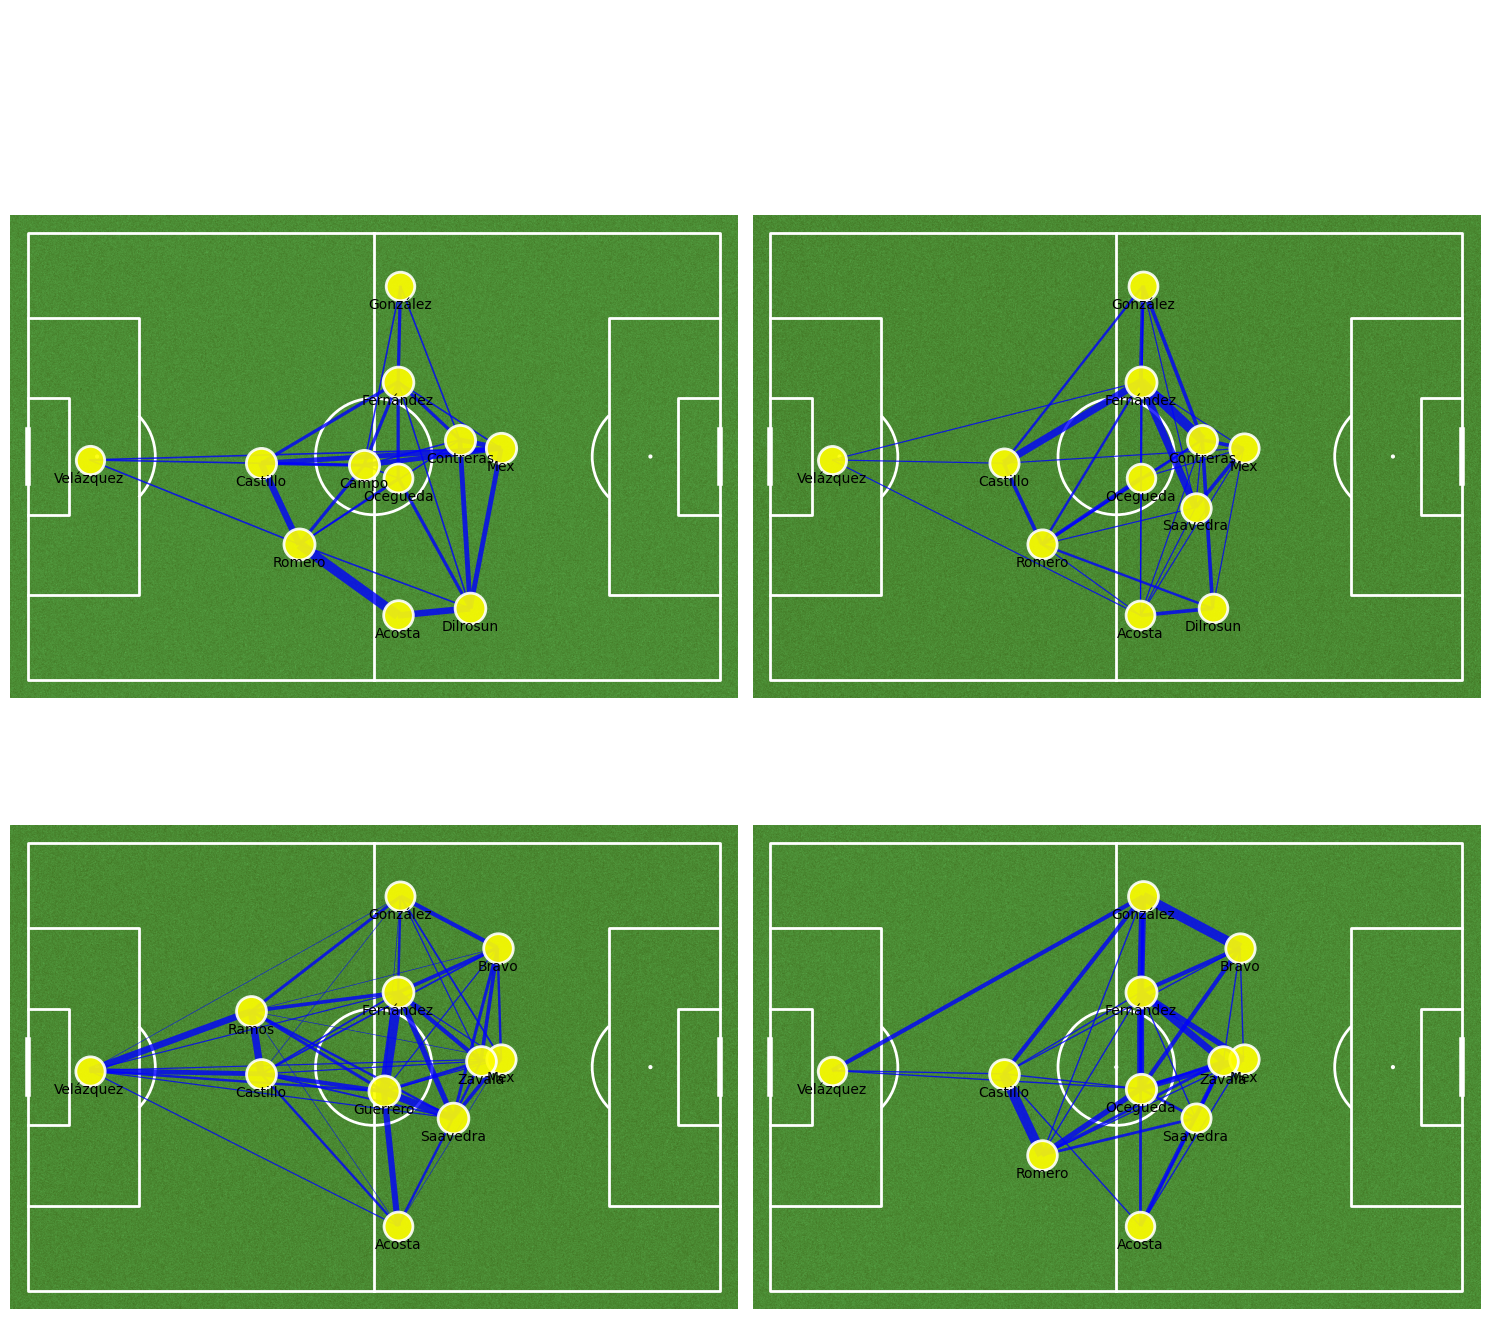

In [72]:
# Lets see what we got

example_match_id = 3972080
example_team_id = 1229       # Ámerica

print('Lets all the passes networks done in a game of Club America')

print("\n")

plot_match_networks(
     match_id=example_match_id,
     team_id=example_team_id,
     final_networks=final_networks,
     player_avg_pos_df=player_avg_pos_df,
     df_players=df_players,
     df_events=df
)